In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xarray.ufuncs import cos, deg2rad, log
import climlab
from metpy.plots import SkewT

In [2]:
# This will try to read the data over the internet.
temperature_filename = 'air.mon.1981-2010.ltm.nc'
humidity_filename = 'shum.mon.1981-2010.ltm.nc'
#  to read over internet
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/"
path = ncep_url
#  Open handle to data
ncep_air = xr.open_dataset(path + temperature_filename, decode_times=False)
ncep_shum = xr.open_dataset(path + humidity_filename, decode_times=False)

In [3]:
#  Take global, annual average and convert to Kelvin
weight = cos(deg2rad(ncep_air.lat)) / cos(deg2rad(ncep_air.lat)).mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time')) 
shum_global = (ncep_shum.shum * weight).mean(dim=('lat','lon','time'))

In [4]:
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/BrianRose/CESM_runs/"
endstr = "/entry.das"
atm_control = xr.open_dataset( datapath + 'som_1850_f19/som_1850_f19.cam.h0.clim.nc' + endstr, decode_times=False)

In [5]:
Qglobal = ((atm_control.Q * atm_control.gw)/atm_control.gw.mean(dim='lat')).mean(dim=('lat','lon','time'))

In [6]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)

In [40]:
rad = climlab.radiation.RRTMG(name='Radiation',
                              state=state, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.33  # tuned to give reasonable ASR for reference cloud-free model
                             )

conv = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment',
                                               state=state,
                                               adj_lapse_rate=6.5,
                                               timestep=rad.timestep,)

rc = rad + conv
rc.name = rad.name

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


In [41]:
rc_noO3 = climlab.process_like(rc)
rc_noO3.subprocess['Radiation'].absorber_vmr['O3'] *= 0.
rc_noO3.name = 'no O3'
rc_noO3.subprocess['Radiation'].name = 'no O3'

rc_noH2O = climlab.process_like(rc)
rc_noH2O.subprocess['Radiation'].specific_humidity *= 0.
rc_noH2O.name = 'no H2O'
rc_noH2O.subprocess['Radiation'].name = 'no H2O'

rc_noO3_noH2O = climlab.process_like(rc_noO3)
rc_noO3_noH2O.subprocess['Radiation'].specific_humidity *= 0.
rc_noO3_noH2O.name = 'no O3, no H2O'
rc_noO3_noH2O.subprocess['Radiation'].name = 'no O3, no H2O'

In [42]:
rc_models = [rc, rc_noO3, rc_noH2O, rc_noO3_noH2O]

In [46]:
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()
    return fig

In [47]:
def integrate_and_plot(model, kind):
    print(model.name)
    for n in range(100):
        model.step_forward()
    while (np.abs(model.ASR-model.OLR)>0.01):
            model.step_forward()
    if kind == 'rc':
        add_profile(skew, model, linestyle='-')
    elif kind == 'rad':
        add_profile(skew, model, linestyle='--')

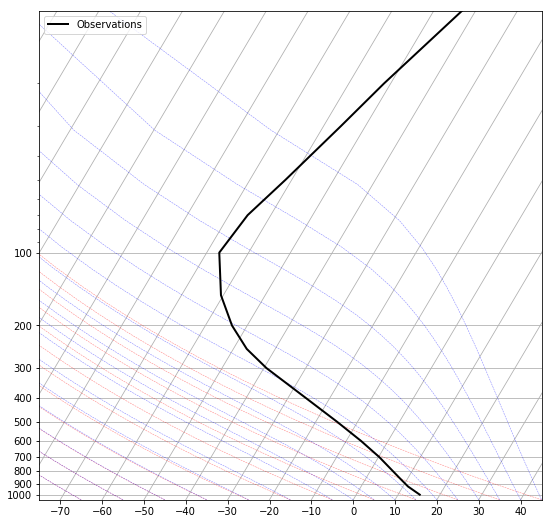

In [48]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)
skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
skew.ax.set_ylim(1050, 10)
skew.ax.set_xlim(-75, 45)
# Add the relevant special lines
skew.plot_dry_adiabats(linewidth=0.5)
skew.plot_moist_adiabats(linewidth=0.5)
#skew.plot_mixing_lines()
skew.ax.legend()

In [49]:
for rcm in rc_models:
    integrate_and_plot(rcm, kind='rc')
    rm = rcm.subprocess['Radiation']
    integrate_and_plot(rm, kind='rad')

Radiation
Radiation
no O3
no O3
no H2O
no H2O
no O3, no H2O
no O3, no H2O


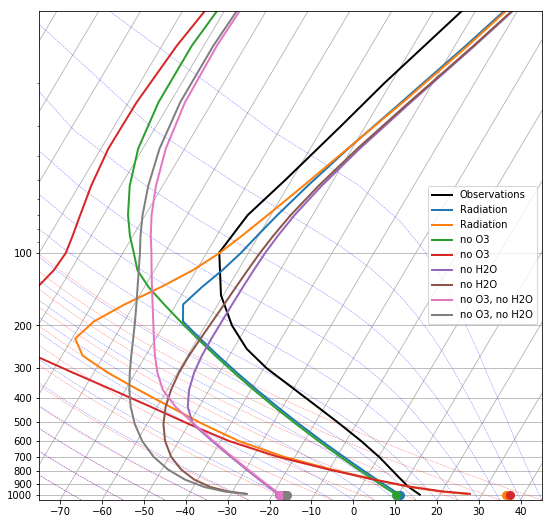

In [50]:
fig